<a href="https://colab.research.google.com/github/DrewRust/DS-Unit-2-Linear-Models/blob/master/U2S1M4_Andrew_Rust_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

1) Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.

In [7]:
print(df.shape)
df.head()

(421, 59)


,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [8]:
# Lots of Nan's not sure what to do about these
df.isnull().sum()

Burrito             0
Date                0
Yelp              334
Google            334
Chips             395
Cost                7
Hunger              3
Mass (g)          399
Density (g/mL)    399
Length            138
Circum            140
Volume            140
Tortilla            0
Temp               20
Meat               14
Fillings            3
Meat:filling        9
Uniformity          2
Salsa              25
Synergy             2
Wrap                3
Unreliable        388
NonSD             414
Beef              242
Pico              263
Guac              267
Cheese            262
Fries             294
Sour cream        329
Pork              370
Chicken           400
Shrimp            400
Fish              415
Rice              385
Beans             386
Lettuce           410
Tomato            414
Bell peper        414
Carrots           420
Cabbage           413
Sauce             383
Salsa.1           414
Cilantro          406
Onion             404
Taquito           417
Pineapple 

In [9]:
df.dtypes

Burrito            object
Date               object
Yelp              float64
Google            float64
Chips              object
Cost              float64
Hunger            float64
Mass (g)          float64
Density (g/mL)    float64
Length            float64
Circum            float64
Volume            float64
Tortilla          float64
Temp              float64
Meat              float64
Fillings          float64
Meat:filling      float64
Uniformity        float64
Salsa             float64
Synergy           float64
Wrap              float64
Unreliable         object
NonSD              object
Beef               object
Pico               object
Guac               object
Cheese             object
Fries              object
Sour cream         object
Pork               object
Chicken            object
Shrimp             object
Fish               object
Rice               object
Beans              object
Lettuce            object
Tomato             object
Bell peper         object
Carrots     

In [0]:
df['Date'] = pd.to_datetime(df.Date)

In [11]:
df['Date'].describe

<bound method NDFrame.describe of 0     2016-01-18
1     2016-01-24
2     2016-01-24
3     2016-01-24
4     2016-01-27
         ...    
418   2019-08-27
419   2019-08-27
420   2019-08-27
421   2019-08-27
422   2019-08-27
Name: Date, Length: 421, dtype: datetime64[ns]>

In [12]:
# Seeing value counts for years
df.Date.dt.year.value_counts()

2016    296
2017     85
2018     27
2019     10
2026      1
2015      1
2011      1
Name: Date, dtype: int64

In [0]:
# get 2016 train
train = df[(df['Date'].dt.year<=2016)] 

In [14]:
# Seeing value counts for years
train.Date.dt.year.value_counts()

2016    296
2015      1
2011      1
Name: Date, dtype: int64

In [0]:
# get 2017 val
val = df[(df['Date'].dt.year==2017)] 

In [16]:
val.Date.dt.year.value_counts()

2017    85
Name: Date, dtype: int64

In [0]:
# get 2018 test
test = df[(df['Date'].dt.year>=2018)] 

In [18]:
test.Date.dt.year.value_counts()

2018    27
2019    10
2026     1
Name: Date, dtype: int64

In [19]:
train.shape, val.shape, test.shape

((298, 59), (85, 59), (38, 59))

2) Begin with baselines for classification (This worked for the last assignment but wrong way for this assignment).

In [0]:
# train['Great'].value_counts()

In [0]:
# train['Great'].mean()

In [0]:
# target = 'Great'
# y_train = train[target]
# y_test = test[target]

In [0]:
# print("Mean Baseline of Great Burrito's (using 0 features)")
# guess = y_train.mean()
# print(guess)
# print(f"This is the percent of Great Burritos: {guess*100:.2f} %")

In [0]:
# from sklearn.metrics import mean_absolute_error
# y_pred = [guess] * len(y_train)
# mae = mean_absolute_error(y_train, y_pred)
# print(f"Train Error (great Burritos): {mae:.3f} %")

In [0]:
# y_pred = [guess] * len(y_test)
# mae = mean_absolute_error(y_test, y_pred)
# print(f'Test Error (great Burritos): {mae:.3f} %')

2) Baseline Continued .. The right way.

In [20]:
target = 'Great'
y_train = train[target]
y_train.value_counts(normalize=True)

False    0.590604
True     0.409396
Name: Great, dtype: float64

In [21]:
# Don't understand what the zero is selecting or why
majority_class = y_train.mode()[0]
majority_class

False

In [0]:
y_train_pred = [majority_class]*len(y_train)

What is the baseline accuracy if we guessed the majority class for every prediction?

In [23]:
# Should match up with the False rate above of .5906

from sklearn.metrics import accuracy_score, mean_absolute_error

accuracy_score(y_train, y_train_pred)

0.5906040268456376

In [24]:
# Will be different in the notes it was slightly less than the above accuracy score.

y_val = val[target]
y_pred = [majority_class]*len(val)
accuracy_score(y_val, y_pred)

0.5529411764705883

Linear Regression (Not part of the assignmen but for my own understanding.

https://srcole.github.io/2016/05/22/100burritos/

1) Volume 

2) tortilla quality 

3) temperature 

4) meat quality 

5) non-meat filling quality 

6) meat filling quality 

7) uniformity 

8) salsa quality 

9) flavor synergy 

10) wrap integrity.

In [25]:
train.describe()

,Yelp,Google,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Queso
count,71.000000,71.000000,292.000000,297.000000,0.0,0.0,175.000000,174.000000,174.000000,298.000000,283.000000,288.000000,297.000000,292.000000,296.000000,278.000000,296.000000,296.000000,0.0
mean,3.897183,4.142254,6.896781,3.445286,NaN,NaN,19.829886,22.042241,0.770920,3.472315,3.706360,3.551215,3.519024,3.528870,3.395946,3.324640,3.540203,3.955068,NaN
std,0.478680,0.371738,1.211412,0.852150,NaN,NaN,2.081275,1.685043,0.137833,0.797606,0.991897,0.869483,0.850348,1.040457,1.089044,0.971226,0.922426,1.167341,NaN
min,2.500000,2.900000,2.990000,0.500000,NaN,NaN,15.000000,17.000000,0.400000,1.400000,1.000000,1.000000,1.000000,0.500000,1.000000,0.000000,1.000000,0.000000,NaN
25%,3.500000,4.000000,6.250000,3.000000,NaN,NaN,18.500000,21.000000,0.662500,3.000000,3.000000,3.000000,3.000000,3.000000,2.500000,2.500000,3.000000,3.500000,NaN
50%,4.000000,4.200000,6.850000,3.500000,NaN,NaN,19.500000,22.000000,0.750000,3.500000,4.000000,3.500000,3.500000,4.000000,3.500000,3.500000,3.750000,4.000000,NaN
75%,4.000000,4.400000,7.500000,4.000000,NaN,NaN,21.000000,23.000000,0.870000,4.000000,4.500000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,NaN
max,4.500000,4.900000,11.950000,5.000000,NaN,NaN,26.000000,27.000000,1.240000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,NaN


In [26]:
train.describe(exclude='number')

,Burrito,Date,Chips,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
count,298,298,22,27,5,168,143,139,149,119,85,43,20,20,5,33,32,11,7,7,1,7,37,6,15,17,4,7,1,4,4,1,4,3,3,2,13,2,1,298
unique,5,110,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,2,1,2
top,California,2016-08-30 00:00:00,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,X,x,False
freq,118,29,19,27,3,130,115,101,121,97,63,29,19,17,3,24,24,9,5,4,1,5,33,5,9,9,3,5,1,4,4,1,4,3,3,2,13,1,1,176
first,NaN,2011-05-16 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2016-12-15 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
train.columns

Index(['Burrito', 'Date', 'Yelp', 'Google', 'Chips', 'Cost', 'Hunger',
       'Mass (g)', 'Density (g/mL)', 'Length', 'Circum', 'Volume', 'Tortilla',
       'Temp', 'Meat', 'Fillings', 'Meat:filling', 'Uniformity', 'Salsa',
       'Synergy', 'Wrap', 'Unreliable', 'NonSD', 'Beef', 'Pico', 'Guac',
       'Cheese', 'Fries', 'Sour cream', 'Pork', 'Chicken', 'Shrimp', 'Fish',
       'Rice', 'Beans', 'Lettuce', 'Tomato', 'Bell peper', 'Carrots',
       'Cabbage', 'Sauce', 'Salsa.1', 'Cilantro', 'Onion', 'Taquito',
       'Pineapple', 'Ham', 'Chile relleno', 'Nopales', 'Lobster', 'Queso',
       'Egg', 'Mushroom', 'Bacon', 'Sushi', 'Avocado', 'Corn', 'Zucchini',
       'Great'],
      dtype='object')

In [28]:
# 1. Import estimator class
from sklearn.linear_model import LinearRegression

# 2. Instantiate this class
linear_reg = LinearRegression()

# 3. Arrange X feature matrices (already did y target vectors)
features = ['Volume', 'Tortilla', 'Temp', 'Meat', 'Fillings', 'Meat:filling', 'Uniformity', 'Salsa', 'Synergy', 'Wrap']
X_train = train[features]
X_val = val[features]

# Impute missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

# 4. Fit the model
linear_reg.fit(X_train_imputed, y_train)

# 5. Apply the model to new data.
# The predictions look like this ...
linear_reg.predict(X_val_imputed)

array([ 0.45444851,  0.48340984,  0.5710718 ,  0.52076343, -0.06185988,
        0.21870354,  0.82723126,  0.58809683, -0.06790102,  0.75404228,
        0.73507725, -0.03363417,  0.30886955,  0.31911894,  1.02187638,
        0.41877888,  0.40025966,  0.6290424 ,  0.65584941,  1.07201469,
        0.61035597,  0.4702118 ,  0.12859104,  0.51542494,  0.64128953,
        0.68111726,  0.92141514,  0.43473777,  0.53547419,  0.68001329,
        0.75256678,  0.43789018,  0.39456971,  0.42664807,  0.29271027,
        0.34932665,  0.47117055,  0.59285274,  0.3782283 ,  0.47010466,
        0.34425164,  0.45731755,  0.49529268,  0.6403574 ,  0.62155129,
        0.52041804, -0.03037343,  0.15055926,  0.53979354, -0.23510658,
        0.18279106,  0.44024287,  0.8190199 ,  0.72193732,  0.42352321,
        0.11262837,  0.23927556,  0.26703441,  0.41472315,  0.3893283 ,
       -0.46597356,  0.33110053, -0.10422001,  0.4330915 ,  0.4341599 ,
        0.73891573,  0.51985085,  1.0670203 ,  0.51463762,  0.41

In [29]:
# Get coefficients
# They all have positive relationships meaning as rating goes up so does the greatness
pd.Series(linear_reg.coef_, features)

Volume          0.039321
Tortilla        0.052752
Temp            0.050511
Meat            0.104226
Fillings        0.108037
Meat:filling    0.061832
Uniformity      0.011564
Salsa           0.043994
Synergy         0.127397
Wrap            0.001975
dtype: float64

In [30]:
print(df['Volume'].mean())
print(df['Tortilla'].mean())
print(df['Temp'].mean())
print(df['Meat'].mean())
print(df['Fillings'].mean())
print(df['Meat:filling'].mean())
print(df['Uniformity'].mean())
print(df['Salsa'].mean())
print(df['Synergy'].mean())
print(df['Wrap'].mean())

0.7864768683274022
3.519477434679334
3.7830423940149633
3.6203931203931203
3.5398325358851666
3.5864805825242727
3.428997613365155
3.371969696969697
3.586992840095464
3.9799043062200954


In [31]:
# Does this mean that it was in the 69% percentile?  I guess that would be it's rating essentially
# Technically this burrito would not be great because it would have to have a 4 / 5 average or above (80% or above)
test_case = [[3, 4, 3, 4, 4, 3, 4, 5, 4, 4]]  # Really good burrito with perfect salsa
linear_reg.predict(test_case)

array([0.69459708])

In [32]:
# This would be a solid Great burrito!
test_case2 = [[4, 4, 4, 4, 4, 4, 4, 4, 4, 4]]  # Really good burrito with perfect salsa
linear_reg.predict(test_case2)

array([0.802266])

3) Use scikit-learn for logistic regression.

In [33]:
# These variables come from the above linear regression (X_train_imputed, X_val_imputed)

from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver='lbfgs')
log_reg.fit(X_train_imputed, y_train)

#print('Validation Accuracy', log_reg.score(X_val_imputed, y_val))
y_pred = log_reg.predict(X_val_imputed)
print(f'Validation accuracy: {accuracy_score(y_val, y_pred)}')

Validation accuracy: 0.8470588235294118


In [34]:
# curious about the shapes
y_val.shape, y_pred.shape

((85,), (85,))

In [35]:
# The predictions look like this
log_reg.predict(X_val_imputed)

array([False, False,  True,  True, False, False,  True,  True, False,
        True,  True, False, False, False,  True, False, False,  True,
        True,  True,  True, False, False, False,  True,  True,  True,
       False,  True,  True,  True, False, False, False, False, False,
        True,  True, False, False, False, False,  True,  True,  True,
        True, False, False,  True, False, False, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True,  True, False,  True,  True,
        True,  True, False, False, False,  True,  True,  True,  True,
        True, False,  True,  True])

In [36]:
# Odd predicted our test case above would be a great burrito
log_reg.predict(test_case)

array([ True])

In [37]:
# What's the math?
log_reg.coef_

array([[ 0.11254045,  0.7651837 ,  0.63536777,  1.46515324,  1.41410715,
         1.22763507, -0.01612778,  0.37332915,  1.75647095,  0.15673198]])

In [38]:
log_reg.intercept_

array([-29.03564154])

In [0]:
# The logistic sigmoid "squishing" function, implemented to accept numpy arrays
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.e**(-x))

In [40]:
log_reg.intercept_ + np.dot(log_reg.coef_, np.transpose(test_case))

array([[0.923711]])

In [41]:
sigmoid(log_reg.intercept_ + np.dot(log_reg.coef_, np.transpose(test_case)))

array([[0.71579764]])

4) Get your model's validation accuracy. (Multiple times if you try multiple iterations.)

Validation accuracy: 0.8470588235294118

In [42]:
# This goes up to 88% after adding more features

#print('Validation Accuracy', log_reg.score(X_val_imputed, y_val))
y_pred = log_reg.predict(X_val_imputed)
print(f'Validation accuracy: {accuracy_score(y_val, y_pred)}')

Validation accuracy: 0.8470588235294118


In [43]:
train.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,2016-01-18,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,2016-01-24,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,2016-01-24,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,2016-01-24,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,2016-01-27,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [44]:
# Added Yelp, google, cost, hunger, length, circum from the already added above features
features = ['Yelp', 'Google', 'Cost', 'Hunger', 'Length', 'Circum', 'Volume', 'Tortilla', 'Temp', 'Meat', 'Fillings', 'Meat:filling', 'Uniformity', 'Salsa', 'Synergy', 'Wrap']
target = 'Great'

X_train = train[features]
X_val = val[features]
y_train = train[target]
y_val = val[target]

X_train.shape, X_val.shape

((298, 16), (85, 16))

In [45]:
import category_encoders as ce 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
encoder = ce.one_hot.OneHotEncoder(use_cat_names=True)
X_train_enc = encoder.fit_transform(X_train)
X_val_enc = encoder.transform(X_val)

In [47]:
# Should be 298
X_train_enc.shape

(298, 16)

In [48]:
X_train_enc.head()

,Yelp,Google,Cost,Hunger,Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap
0,3.5,4.2,6.49,3.0,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0
1,3.5,3.3,5.45,3.5,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0
2,NaN,NaN,4.85,1.5,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0
3,NaN,NaN,5.25,2.0,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0
4,4.0,3.8,6.59,4.0,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0


In [0]:
imputer = SimpleImputer()
X_train_imp = imputer.fit_transform(X_train_enc)
X_val_imp = imputer.transform(X_val_enc)

In [50]:
# should be 298
X_train_imp.shape

(298, 16)

In [0]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_imp)
X_val_sc = scaler.transform(X_val_imp)

In [0]:
X_train_sc = pd.DataFrame(X_train_sc, columns=X_train_enc.columns)
X_val_sc = pd.DataFrame(X_val_sc, columns=X_val_enc.columns)

In [53]:
X_train_sc.head()

,Yelp,Google,Cost,Hunger,Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap
0,-1.712002e+00,3.205145e-01,-0.339805,-0.524307,0.0,0.0,0.0,-0.593162,1.340696,-0.645992,-0.022447,0.458224,0.557478,0.721245,0.500993,0.038686
1,-1.712002e+00,-4.674821e+00,-1.208571,0.064423,0.0,0.0,0.0,-1.849023,-0.213867,-1.231964,-1.202403,-1.486989,0.557478,0.187274,-1.133401,0.899679
2,1.914185e-15,-4.929721e-15,-1.709783,-2.290496,0.0,0.0,0.0,-0.593162,-1.768429,-1.231964,-0.612425,0.944528,0.557478,-0.346697,-0.588603,0.899679
3,1.914185e-15,-4.929721e-15,-1.375642,-1.701766,0.0,0.0,0.0,-0.593162,-1.768429,-0.060021,-0.612425,0.458224,1.480371,0.721245,0.500993,0.899679
4,4.431779e-01,-1.899635e+00,-0.256270,0.653153,0.0,0.0,0.0,0.662698,1.340696,0.525950,-0.022447,0.944528,1.480371,-0.880668,1.045791,0.038686


In [54]:
model = LogisticRegressionCV()
model.fit(X_train_sc, y_train)
y_pred = model.predict(X_val_sc)
print(f'Validation accuracy: {accuracy_score(y_val, y_pred)}')

Validation accuracy: 0.8823529411764706


In [55]:
# curious about the shapes
X_train_sc.shape, y_train.shape

((298, 16), (298,))

In [56]:
# Curious about the shapes
y_val.shape, y_pred.shape

((85,), (85,))

**Validation accuracy: 0.8823529411764706**

In [57]:
coefs = model.coef_[0]
coefs = pd.Series(coefs, X_train_sc.columns)
coefs

Yelp            0.093854
Google         -0.004266
Cost            0.195676
Hunger          0.119757
Length          0.042483
Circum          0.000300
Volume         -0.002146
Tortilla        0.309644
Temp            0.284428
Meat            0.577196
Fillings        0.579293
Meat:filling    0.492726
Uniformity      0.165661
Salsa           0.257620
Synergy         0.685466
Wrap            0.102378
dtype: float64

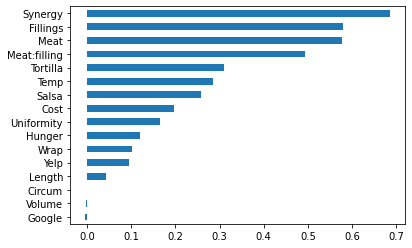

In [58]:
# volume and google have negative coeficients
coefs.sort_values().plot.barh()

5) Get your model's test accuracy. (One time, at the end.)

In [59]:
test.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
77,California,2026-04-25,NaN,NaN,NaN,8.00,4.0,NaN,NaN,21.59,NaN,NaN,4.5,5.0,5.0,5.0,4.5,5.0,3.0,5.0,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
386,California,2018-01-02,NaN,NaN,NaN,7.25,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,5.0,5.0,3.0,3.0,4.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
387,Other,2018-01-09,4.5,3.8,NaN,4.19,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,2.0,2.0,4.0,1.0,4.0,3.0,4.0,x,NaN,NaN,NaN,NaN,x,NaN,x,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,False
388,California,2018-01-12,3.5,4.3,NaN,7.00,5.0,NaN,NaN,NaN,NaN,NaN,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
389,Other,2018-01-12,NaN,NaN,NaN,8.50,4.0,NaN,NaN,21.00,23.5,0.92,4.0,4.0,3.0,3.5,1.0,2.0,3.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [0]:
# test_drop_great = test.drop(['Great'], axis = 1)

In [0]:
# test_drop_great.head()

In [60]:
features

['Yelp',
 'Google',
 'Cost',
 'Hunger',
 'Length',
 'Circum',
 'Volume',
 'Tortilla',
 'Temp',
 'Meat',
 'Fillings',
 'Meat:filling',
 'Uniformity',
 'Salsa',
 'Synergy',
 'Wrap']

In [61]:
X_test = test[features]
X_test_enc = encoder.transform(X_test)
X_test_imp = imputer.transform(X_test_enc)
X_test_sc = scaler.transform(X_test_imp)
X_test_sc

array([[ 1.91418451e-15, -4.92972144e-15,  9.21576515e-01,
         6.53153184e-01,  1.10673835e+00,  0.00000000e+00,
         0.00000000e+00,  1.29062863e+00,  1.34069563e+00,
         1.69789203e+00,  1.74748664e+00,  9.44527829e-01,
         1.48037108e+00, -3.46697110e-01,  1.59058956e+00,
         8.99678662e-01],
       [ 1.91418451e-15, -4.92972144e-15,  2.95062401e-01,
         6.53153184e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  6.62698293e-01,  1.34069563e+00,
         5.25949777e-01,  1.74748664e+00,  1.43083126e+00,
        -3.65415944e-01, -3.46697110e-01,  5.00993379e-01,
         8.99678662e-01],
       [ 2.59835806e+00, -1.89963467e+00, -2.26111518e+00,
        -5.24306577e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -5.93162383e-01,  1.34069563e+00,
        -1.81793472e+00, -1.79238058e+00,  4.58224401e-01,
        -2.21120297e+00,  7.21245234e-01, -5.88602801e-01,
         3.86864734e-02],
       [-1.71200227e+00,  8.75551784e

In [62]:
y_pred = model.predict(X_test_sc)
y_pred

array([ True,  True, False,  True, False, False,  True,  True, False,
        True,  True, False,  True, False,  True,  True,  True, False,
       False, False, False,  True, False,  True,  True, False, False,
        True,  True,  True, False,  True,  True, False,  True,  True,
        True,  True])

In [63]:
# I figured out the dimensions didn't match up here
print(X_test_sc.shape, y_train.shape)
print(y_val.shape, y_pred.shape)

(38, 16) (298,)
(85,) (38,)


In [0]:
# This is just for reference (this is how it was done above)

# X_train = train[features]
# X_val = val[features]
# y_train = train[target]
# y_val = val[target]

# X_train.shape, X_val.shape

In [0]:
# X_test = test[features]
y_test = test[target]

In [65]:
# Doesn't have the same dimensions
print(X_test_sc.shape, y_test.shape)
print(y_val.shape, y_pred.shape)

(38, 16) (38,)
(85,) (38,)


In [66]:
# Dimensions match up!
X_train_sc.shape, y_train.shape

((298, 16), (298,))

In [67]:
# Dimensions match up!
y_test.shape, y_pred.shape

((38,), (38,))

In [68]:
# Pretty sure this is how to get the test accuracy.  The above examples

model = LogisticRegressionCV()
model.fit(X_train_sc, y_train)
# y_pred was done above seperate
# y_pred = model.predict(X_test_sc)
# put y_test in there for test has to have the same dimensions
print(f'Validation accuracy: {accuracy_score(y_test, y_pred)}')

Validation accuracy: 0.7631578947368421


**TEST accuracy: 0.7631578947368421**

In [0]:
test

In [69]:
# This should work because it's only selected by date
submission = test[['Burrito']].copy()
submission

,Burrito
77,California
386,California
387,Other
388,California
389,Other
390,Asada
391,Carnitas
392,Carnitas
393,Carnitas
394,California


In [0]:
submission["Is_it_Great?"] = y_pred

In [0]:
actual_greats = test['Great']

In [0]:
submission = submission.join(actual_greats)

In [73]:
submission.head()

,Burrito,Is_it_Great?,Great
77,California,True,True
386,California,True,False
387,Other,False,False
388,California,True,True
389,Other,False,False


In [0]:
# Have to reset index on new df
submission = submission.reset_index(drop=True)

In [75]:
submission.head()

,Burrito,Is_it_Great?,Great
0,California,True,True
1,California,True,False
2,Other,False,False
3,California,True,True
4,Other,False,False


In [0]:
x = 0
for ind in submission.index:
  if (submission["Is_it_Great?"][ind] == submission["Great"][ind]):
    x += 1
  else:
    continue


Matches above!

Validation accuracy: 0.7631578947368421

In [78]:
print(x)
print(len(submission))
print(x / (len(submission)))

29
38
0.7631578947368421
